In [1]:
#need to install packages to read files, work with the data, and conduct regression analysis

!pip install xlrd==2.0.1
!pip install openpyxl
!pip install statsmodels==0.14.1

import pandas as pd
import numpy as np
import xlrd as xlrd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

#packages ready

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 16.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 23.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 25.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [2]:
#need to load the primary file (fafsa data) and then clean


df = pd.read_excel('HSARCHIVE04302023.xls', skiprows = 1, header = 2)
df.drop(df.columns[[4, 5, 6, 8, 9, 10, 11]], axis = 1, inplace = True)
df.columns = ['school_code', 'school_name', 'school_city', 'school_state', 'completed_fafsa']
df['school_city_state'] = df['school_city'] + ', ' + df['school_state']
df = df[~df['school_state'].str.contains('PR|MP|AS|FM|GU|MH|PW|VI|FC')]
df['completed_fafsa'] = df['completed_fafsa'].replace('<5', 1)
df['completed_fafsa'] = df['completed_fafsa'].astype(int)
df_crosswalk = pd.read_excel('school_city_to_county_crosswalk.xls', skiprows = 0, header = 0)
df_crosswalk.columns = ['fips', 'city_state', 'school_code']
df_fafsa = pd.merge(df, df_crosswalk, on = 'school_code', how = 'left')
df_fafsa = df_fafsa.groupby('fips')['completed_fafsa'].sum().reset_index()
df_fafsa

#primary file is loaded and cleaned, i.e., variables renamed, US territories removed from the data set, county assigned to school, and fafsa completion data summed by county; for schools with "<5" completions this value was changed to 1 in the data set

,fips,completed_fafsa
0,1001,268
1,1003,1292
2,1005,188
3,1007,89
4,1009,317
...,...,...
3109,56037,153
3110,56039,122
3111,56041,83
3112,56043,42


In [3]:
#need to get estimated grade 12 enrollments by county to calculate fafsa completion percentages as the outcome variable

df_elsi = pd.read_excel('ELSI_Schools.xlsx', skiprows = 0, header = 1)
df_elsi.columns = ['school_name', 'school_state_name', 'school_code', 'fips', 'grade_12_enrollment']
df_elsi = df_elsi.groupby('fips')['grade_12_enrollment'].sum().reset_index()
df_fafsa_and_nces = pd.merge(df_fafsa, df_elsi, on = 'fips', how = 'left')
df_fafsa_and_nces['completed_fafsa_perc'] = df_fafsa_and_nces['completed_fafsa'] / df_fafsa_and_nces['grade_12_enrollment'] * 100
df_fafsa_and_nces['completed_fafsa_perc'] = df_fafsa_and_nces['completed_fafsa_perc'].round(4)
df_fafsa_and_nces = df_fafsa_and_nces[df_fafsa_and_nces['completed_fafsa'] >= 10]
df_fafsa_and_nces.loc[df_fafsa_and_nces['fips'].isin(['17151', '19119', '31089']), 'completed_fafsa_perc'] = 100

df_fafsa_and_nces

#school enrollment data is joined to fafsa data set and fafsa completion percentages calculated. three counties had percentages greater than 100.0%: 17151 16/10 = 160%; 19119 145/150 = 102%; 31089 94/92 = 102%; percentages capped at 100%
#further, a decision is made to drop counties with fewer than 10 completed fafsas to minimize potential estimation error

,fips,completed_fafsa,grade_12_enrollment,completed_fafsa_perc
0,1001,268,663,40.4223
1,1003,1292,2455,52.6273
2,1005,188,382,49.2147
3,1007,89,202,44.0594
4,1009,317,633,50.0790
...,...,...,...,...
3109,56037,153,497,30.7847
3110,56039,122,244,50.0000
3111,56041,83,328,25.3049
3112,56043,42,95,44.2105


In [4]:
#now that fafsa data is compiled, socioeconomic health and demographic data needs to be joined to the data set
#data from four files from the US Census Bureau are joined in

df_education = pd.read_excel('Education.xlsx', skiprows = 1, header = 2)
df_education = df_education.drop(columns = df_education.columns[3:54])
df_education.columns = ['fips', 'state', 'county', 'edu_attainment']

df_pov = pd.read_excel('PovertyEstimates.xlsx', skiprows = 1, header = 3)
df_pov = df_pov.drop(columns = df_pov.columns[1:7])
df_pov = df_pov.drop(columns = df_pov.columns[2:4])
df_pov = df_pov.drop(columns = df_pov.columns[3:17])
df_pov = df_pov.drop(columns = df_pov.columns[4:14])
df_pov.columns = ['fips', 'total_poverty', 'poverty_rate', 'hh_med_inc']
df_pov['hh_med_inc_log'] = np.log(df_pov['hh_med_inc']+1).round(4)

df_unemp = pd.read_excel('Unemployment.xlsx', skiprows = 1, header = 3)
df_unemp = df_unemp.drop(columns = df_unemp.columns[1:93])
df_unemp = df_unemp.drop(columns = df_unemp.columns[2:8])
df_unemp.columns = ['fips', 'unemp_rate']

df_race = pd.read_csv('B03002 Race.csv', skiprows = 0, header = 1)
df_race = df_race.drop(columns = df_race.columns[1])
df_race = df_race.drop(columns = df_race.columns[2:5])
df_race = df_race.drop(columns = df_race.columns[3:1000])
df_race.columns = ['fips', 'total_pop', 'white_nonhisp']
df_race['white_nonhisp_perc'] = (df_race['white_nonhisp'] / df_race['total_pop'] * 100).round(4)
df_race['total_pop_log'] = np.log(df_race['total_pop']+1).round(4)

df_census = pd.merge(pd.merge(pd.merge(df_education, df_pov, on = 'fips', how = 'left'), df_unemp, on = 'fips', how = 'left'), df_race, on = 'fips', how = 'left')
df_fafsa_census = pd.merge(df_fafsa_and_nces, df_census, on = 'fips', how = 'left')
df_fafsa_census['grade_12_enrollment_log'] = np.log(df_fafsa_census['grade_12_enrollment']+1).round(4)
df_fafsa_census['white_nonhisp_perc_sq'] = df_fafsa_census['white_nonhisp_perc'] * df_fafsa_census['white_nonhisp_perc']

df_fafsa_census

#the final data set is ready after joining US Census data

,fips,completed_fafsa,grade_12_enrollment,completed_fafsa_perc,state,county,edu_attainment,total_poverty,poverty_rate,hh_med_inc,hh_med_inc_log,unemp_rate,total_pop,white_nonhisp,white_nonhisp_perc,total_pop_log,grade_12_enrollment_log,white_nonhisp_perc_sq
0,1001,268,663,40.4223,AL,Autauga County,28.131469,6296.0,10.7,66444.0,11.1041,2.8,58761.0,42635.0,72.5566,10.9813,6.4983,5264.460204
1,1003,1292,2455,52.6273,AL,Baldwin County,32.450286,25526.0,10.8,65658.0,11.0922,2.9,233420.0,192161.0,82.3241,12.3606,7.8063,6777.257441
2,1005,188,382,49.2147,AL,Barbour County,11.153098,5089.0,23.0,38649.0,10.5623,5.5,24877.0,11084.0,44.5552,10.1217,5.9480,1985.165847
3,1007,89,202,44.0594,AL,Bibb County,11.913807,4204.0,20.6,48454.0,10.7884,3.4,22251.0,16520.0,74.2439,10.0102,5.3132,5512.156687
4,1009,317,633,50.0790,AL,Blount County,14.903610,6992.0,12.0,56894.0,10.9490,2.4,59077.0,50614.0,85.6746,10.9866,6.4520,7340.137085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3021,56037,153,497,30.7847,WY,Sweetwater County,19.391717,3761.0,9.2,74677.0,11.2209,5.7,42079.0,32751.0,77.8322,10.6473,6.2106,6057.851357
3022,56039,122,244,50.0000,WY,Teton County,57.868509,1392.0,5.9,102709.0,11.5397,3.3,23346.0,18598.0,79.6625,10.0582,5.5013,6346.113906
3023,56041,83,328,25.3049,WY,Uinta County,17.955112,1917.0,9.4,70162.0,11.1586,5.2,20546.0,17826.0,86.7614,9.9305,5.7961,7527.540530
3024,56043,42,95,44.2105,WY,Washakie County,26.166329,773.0,10.2,62176.0,11.0377,4.1,7725.0,6301.0,81.5663,8.9523,4.5643,6653.061296


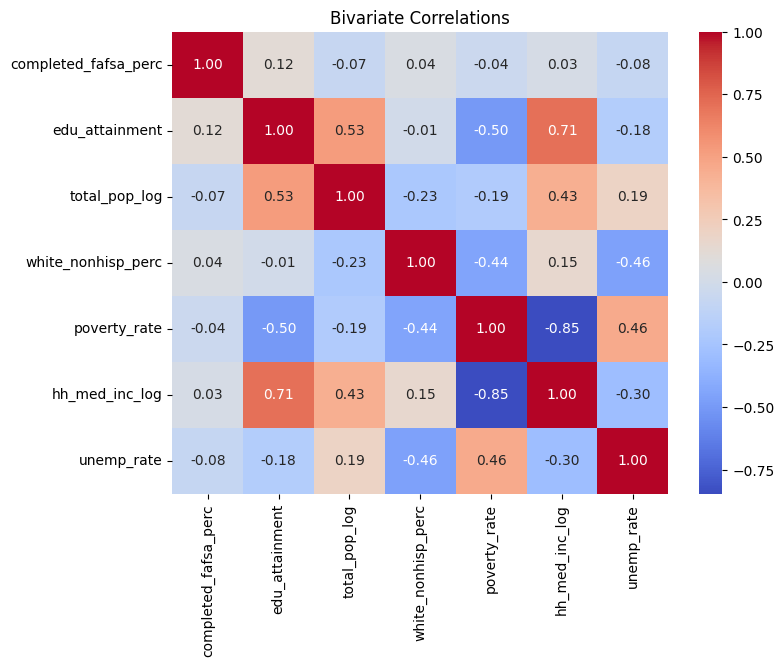

In [5]:
#need to perform initial exploratory analyses, i.e., bivariate correlations

df_correl = pd.DataFrame(df_fafsa_census)
correl_matrix = df_correl[['completed_fafsa_perc', 'edu_attainment', 'total_pop_log', 'white_nonhisp_perc', 'poverty_rate', 'hh_med_inc_log', 'unemp_rate']].corr()

plt.figure(figsize = (8, 6))
sns.heatmap(correl_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Bivariate Correlations')
plt.show()

#potential mulitcollinearity when examining associations between income and both poverty and educational attainment, thus, income not to be included in regression

In [6]:
#need to develop a model to examine associations between socioeconomic health indicators, demographics, and fafsa completion rate

predictors = ['edu_attainment', 'total_pop_log', 'white_nonhisp_perc', 'poverty_rate', 'unemp_rate', 'white_nonhisp_perc_sq']
target = 'completed_fafsa_perc'
X = df_fafsa_census[predictors]
y = df_fafsa_census[target]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

#ultimately, a model with first-order terms and a second-order race and ethnicity term was obtained; model performs poorly in terms of explained variance indicating more work to be done in terms of identifying factors that relate to fafsa completion rates

                             OLS Regression Results                             
Dep. Variable:     completed_fafsa_perc   R-squared:                       0.053
Model:                              OLS   Adj. R-squared:                  0.051
Method:                   Least Squares   F-statistic:                     28.30
Date:                  Tue, 19 Dec 2023   Prob (F-statistic):           4.49e-33
Time:                          03:47:49   Log-Likelihood:                -12113.
No. Observations:                  3026   AIC:                         2.424e+04
Df Residuals:                      3019   BIC:                         2.428e+04
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

In [11]:
#want to report some basic statisics on the primary measure of interest: FAFSA completion rate

fafsa_mean = df_fafsa_census['completed_fafsa_perc'].mean()
fafsa_mean

46.84742538003966

In [10]:
fafsa_stdev = df_fafsa_census['completed_fafsa_perc'].std()
fafsa_stdev

#calculations of the mean and standard deviation for fafsa completion percentage

13.622192311743094

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7a2f85b1-2912-4af4-a7c5-f26c96c712f9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>